In [1]:
%store -r import_all_libs

In [2]:
import_all_libs

In [3]:
width, height = 30, 10 # example with 15x6 inches
plt.rcParams['figure.figsize'] = [width, height]
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# NRC Analysis

Análise de dados do Nike Run Club

In [4]:
from os import listdir
from os.path import isfile, join
import json
from datetime import datetime

# reads files from this folder
path = '/home/tuts/health_data/activities/'
files = [f for f in listdir(path) if isfile(join(path, f))]

In [5]:
data = list()
for file in files:
    # loads json files into a list
    file_path = f'/home/tuts/health_data/activities/{file}'
    data.append(json.load(open(f'{file_path}',"rb")))

### Etapa de leitura dos dados

Os dados estão em formato json.

In [6]:
df = pd.DataFrame()
for d in data:
    normalized_d = pd.json_normalize(d)
        
    normalized_d_filtered = normalized_d[['summaries', 'tags.location', 'metrics']]
    
    # summary contains entry metric values
    prov = pd.json_normalize(normalized_d_filtered.summaries[0])
    
    # get the unit for a metric
    metric = {
        'distance': 'KM',
        'steps': 'N',
        'speed': 'KMH',
        'calories': 'KCAL',
        'heart_rate': 'BPM',
        'pace': 'MKM',
        'nikefuel': 'FUEL',
        'rpe': 'RATING',
        'ascent': 'M',
        'descent': 'M'
    }
    
    prov['metric_all'] = prov.metric+'_'+prov.summary+'_'+prov.metric.apply(lambda x: metric.get(x))
    
    final = prov[['metric_all', 'value']].T
    final = final.reset_index(drop=True)
    final.columns = final.iloc[0]
    final = final.tail(1).reset_index(drop=True)

    # indoor or outdoor
    final['ambiente'] = normalized_d["tags.location"]
    final['inicio'] = (normalized_d['start_epoch_ms'] / 1000).apply(lambda x: datetime.fromtimestamp(x))
    final['fim'] = (normalized_d['end_epoch_ms'] / 1000).apply(lambda x: datetime.fromtimestamp(x))
    
    if 'tags.com.nike.running.recordingsource' in normalized_d.columns:
        final['source'] = normalized_d["tags.com.nike.running.recordingsource"]
    
    if 'tags.com.nike.temperature' in normalized_d.columns:
        final['temp_C'] = normalized_d["tags.com.nike.temperature"]
        
    if 'tags.com.nike.running.startlocation' in normalized_d.columns:
        final['local_inicio'] = normalized_d["tags.com.nike.running.startlocation"]
        
    if 'tags.com.nike.weather' in normalized_d.columns:
        final['clima'] = normalized_d["tags.com.nike.weather"]

    df = df.append(final).reset_index(drop=True)

## Dados

Os dados contém informações relativas a distância, pace médio, número de passos, batimentos cardiacos, velocidade média, calorias, ambiente da corrida, início e fim da corrida, subida e descida total, temperatura, local de início e clima.

In [7]:
df = df.sort_values(by=['inicio'])
df.head()

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ambiente,inicio,fim,source,ascent_total_M,descent_total_M,rpe_max_RATING,temp_C,local_inicio,clima
27,4.685079,980.027373,13.162969,6630.0,NaN,4.558242,15.891593,269.367,outdoors,2018-03-03 15:18:09.767,2018-03-03 16:23:23.835,NaN,19.500305,73.842224,NaN,26.6,"-23.5895234741968,-46.6351430075065",rainy
18,2.760267,560.719267,13.108273,3785.0,NaN,4.577262,15.497046,157.393,outdoors,2018-03-06 18:51:07.527,2018-03-06 19:30:19.597,NaN,2.179871,27.281921,NaN,23.3,"-23.5563445869079,-46.7210175019518",rainy
39,7.049688,1814.680542,7.270024,NaN,NaN,8.253068,35.407434,536.997,outdoors,2019-09-15 09:02:36.571,2019-09-15 09:57:13.418,NaN,32.397522,34.712219,6.0,20.3,"-23.588000974989793,-46.65678188904476",partly_sunny
25,6.1469,1557.103291,6.783105,NaN,NaN,8.845507,37.345025,478.151,indoors,2019-09-17 19:41:15.681,2019-09-17 20:23:29.481,NaN,9.08429,11.594482,5.0,NaN,NaN,NaN
1,11.324092,2981.907749,7.008792,NaN,NaN,8.560677,37.57056,872.246,outdoors,2019-09-22 08:32:14.603,2019-09-22 09:52:43.185,NaN,75.012817,76.281189,5.0,17.1,"-23.562622077487777,-46.712824205364115",cloudy


In [8]:
df.isna().sum()

0
distance_total_KM       0
nikefuel_total_FUEL     0
pace_mean_MKM           0
steps_total_N          16
heart_rate_mean_BPM    21
speed_mean_KMH          0
nikefuel_mean_FUEL      0
calories_total_KCAL     0
ambiente                0
inicio                  0
fim                     0
source                 18
ascent_total_M         14
descent_total_M        14
rpe_max_RATING         28
temp_C                 16
local_inicio           25
clima                  16
dtype: int64

In [9]:
df.isna().sum().sum()

168

### Informações sobre os dados

In [10]:
df.distance_total_KM = df.distance_total_KM.astype(float)
df.nikefuel_total_FUEL = df.nikefuel_total_FUEL.astype(float)
df.pace_mean_MKM = df.pace_mean_MKM.astype(float)
df.steps_total_N = pd.to_numeric(df['steps_total_N'], errors='coerce')
df.heart_rate_mean_BPM = df.heart_rate_mean_BPM.astype(float)
df.speed_mean_KMH = df.speed_mean_KMH.astype(float)
df.nikefuel_mean_FUEL = df.nikefuel_mean_FUEL.astype(float)
df.calories_total_KCAL = df.calories_total_KCAL.astype(float)
df.ambiente = df.ambiente.astype(str)
# df.inicio = df.temp_C.astype(float)
# df.fim = df.temp_C.astype(float)
df.source = df.source.astype(str)
df.ascent_total_M = df.ascent_total_M.astype(float)
df.descent_total_M = df.descent_total_M.astype(float)
df.rpe_max_RATING = df.rpe_max_RATING.astype(str)
df.local_inicio = df.local_inicio.astype(str)
df.clima = df.clima.astype(str)
df.temp_C = df.temp_C.astype(float)

In [11]:
df.isna().sum()

0
distance_total_KM       0
nikefuel_total_FUEL     0
pace_mean_MKM           0
steps_total_N          16
heart_rate_mean_BPM    21
speed_mean_KMH          0
nikefuel_mean_FUEL      0
calories_total_KCAL     0
ambiente                0
inicio                  0
fim                     0
source                  0
ascent_total_M         14
descent_total_M        14
rpe_max_RATING          0
temp_C                 16
local_inicio            0
clima                   0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 27 to 30
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   distance_total_KM    41 non-null     float64       
 1   nikefuel_total_FUEL  41 non-null     float64       
 2   pace_mean_MKM        41 non-null     float64       
 3   steps_total_N        25 non-null     float64       
 4   heart_rate_mean_BPM  20 non-null     float64       
 5   speed_mean_KMH       41 non-null     float64       
 6   nikefuel_mean_FUEL   41 non-null     float64       
 7   calories_total_KCAL  41 non-null     float64       
 8   ambiente             41 non-null     object        
 9   inicio               41 non-null     datetime64[ns]
 10  fim                  41 non-null     datetime64[ns]
 11  source               41 non-null     object        
 12  ascent_total_M       27 non-null     float64       
 13  descent_total_M      27 non-null    

In [13]:
print(f'Número de corridas: {len(df)}')
print(f'Total de kms: {df.distance_total_KM.sum()}')
print(f'Distância média por corrida: {df.distance_total_KM.mean()}')
print(f'Pace médio: {df.pace_mean_MKM.mean()}')
print(f'Batimento médio: {df.heart_rate_mean_BPM.mean()}')
print(f'Total de kcals: {df.calories_total_KCAL.mean()}')

Número de corridas: 41
Total de kms: 181.56197732756877
Distância média por corrida: 4.428340910428507
Pace médio: 8.062136284901014
Batimento médio: 143.27646014704501
Total de kcals: 348.82534146341465


## Data exploration

#### Numericals

In [14]:
df.describe(percentiles=[.8, .95, .99])

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ascent_total_M,descent_total_M,temp_C
count,41.000000,41.000000,41.000000,25.000000,20.000000,41.000000,41.000000,41.000000,27.000000,27.000000,25.0000
mean,4.428341,1113.720685,8.062136,3014.440000,143.276460,7.721706,32.308659,348.825341,57.188209,59.710509,22.3796
std,3.158879,814.546420,1.746264,1560.506063,18.649364,1.358378,7.948860,239.091544,45.838925,44.552784,3.0853
min,0.177669,37.503823,5.950347,182.000000,104.010309,4.558242,15.497046,11.462000,2.179871,6.885925,17.1000
50%,3.638666,959.428604,7.476316,3434.000000,148.852050,8.025343,34.449426,309.556000,50.809204,53.882202,21.8000
80%,6.734412,1723.000606,8.751978,4037.400000,158.463278,8.802724,38.333216,520.928000,78.143286,75.862598,23.9160
95%,11.153372,2813.362058,11.809370,4818.400000,163.219569,9.328297,42.512366,845.126000,148.163550,141.542694,28.6800
99%,12.686134,3150.940009,13.141091,6220.800000,166.058651,9.936161,45.537849,942.075800,162.165420,159.850704,29.7320
max,13.594162,3263.628182,13.162969,6630.000000,166.768421,10.083445,45.972302,988.629000,163.924133,164.066833,29.9000


In [15]:
df.select_dtypes(include=['object']).describe()

,ambiente,source,rpe_max_RATING,local_inicio,clima
count,41,41,41,41,41
unique,2,3,6,17,7
top,outdoors,watch,nan,nan,nan
freq,25,19,28,25,16


In [16]:
df.clima.value_counts()

nan                    16
partly-cloudy-day       7
partly_sunny            6
cloudy                  5
rainy                   3
partly_cloudy_night     3
fog                     1
Name: clima, dtype: int64

Porcentagem de corridas por ambiente

In [17]:
df.ambiente.value_counts(normalize=True)*100

outdoors    60.97561
indoors     39.02439
Name: ambiente, dtype: float64

## Feature engineering

In [18]:
def p90(x):
    return x.quantile(0.9)

In [52]:
df['days_diff'] = df.fim.diff().dt.days
df['distance_total_diff'] = df.distance_total_KM.diff()
df['day_name'] = df.fim.dt.day_name()
df['hour_of_the_day'] = df.inicio.dt.hour.astype(str)
df['temperature_feeling'] = df['temp_C'].apply(lambda t: 'hot' if t > 26 else 'normal' if t > 22 else 'cold' if not pd.isnull(t) else None)

In [54]:
df.head()

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ambiente,inicio,fim,source,ascent_total_M,descent_total_M,rpe_max_RATING,temp_C,local_inicio,clima,days_diff,distance_total_diff,day_name,hour_of_the_day,temperature_feeling
27,4.685079,980.027373,13.162969,6630.0,NaN,4.558242,15.891593,269.367,outdoors,2018-03-03 15:18:09.767,2018-03-03 16:23:23.835,nan,19.500305,73.842224,nan,26.6,"-23.5895234741968,-46.6351430075065",rainy,NaN,NaN,Saturday,15,hot
18,2.760267,560.719267,13.108273,3785.0,NaN,4.577262,15.497046,157.393,outdoors,2018-03-06 18:51:07.527,2018-03-06 19:30:19.597,nan,2.179871,27.281921,nan,23.3,"-23.5563445869079,-46.7210175019518",rainy,3.0,-1.924812,Tuesday,18,normal
39,7.049688,1814.680542,7.270024,NaN,NaN,8.253068,35.407434,536.997,outdoors,2019-09-15 09:02:36.571,2019-09-15 09:57:13.418,nan,32.397522,34.712219,6.0,20.3,"-23.588000974989793,-46.65678188904476",partly_sunny,557.0,4.289421,Sunday,9,cold
25,6.146900,1557.103291,6.783105,NaN,NaN,8.845507,37.345025,478.151,indoors,2019-09-17 19:41:15.681,2019-09-17 20:23:29.481,nan,9.084290,11.594482,5.0,NaN,nan,nan,2.0,-0.902788,Tuesday,19,None
1,11.324092,2981.907749,7.008792,NaN,NaN,8.560677,37.570560,872.246,outdoors,2019-09-22 08:32:14.603,2019-09-22 09:52:43.185,nan,75.012817,76.281189,5.0,17.1,"-23.562622077487777,-46.712824205364115",cloudy,4.0,5.177192,Sunday,8,cold


In [21]:
df.describe(percentiles=[.8, .95, .99])

,distance_total_KM,nikefuel_total_FUEL,pace_mean_MKM,steps_total_N,heart_rate_mean_BPM,speed_mean_KMH,nikefuel_mean_FUEL,calories_total_KCAL,ascent_total_M,descent_total_M,temp_C,days_diff,distance_total_diff
count,41.000000,41.000000,41.000000,25.000000,20.000000,41.000000,41.000000,41.000000,27.000000,27.000000,25.0000,40.0000,40.000000
mean,4.428341,1113.720685,8.062136,3014.440000,143.276460,7.721706,32.308659,348.825341,57.188209,59.710509,22.3796,34.8250,-0.054509
std,3.158879,814.546420,1.746264,1560.506063,18.649364,1.358378,7.948860,239.091544,45.838925,44.552784,3.0853,142.0128,2.941123
min,0.177669,37.503823,5.950347,182.000000,104.010309,4.558242,15.497046,11.462000,2.179871,6.885925,17.1000,0.0000,-6.061232
50%,3.638666,959.428604,7.476316,3434.000000,148.852050,8.025343,34.449426,309.556000,50.809204,53.882202,21.8000,3.0000,-0.123795
80%,6.734412,1723.000606,8.751978,4037.400000,158.463278,8.802724,38.333216,520.928000,78.143286,75.862598,23.9160,5.2000,1.487728
95%,11.153372,2813.362058,11.809370,4818.400000,163.219569,9.328297,42.512366,845.126000,148.163550,141.542694,28.6800,40.2000,5.182424
99%,12.686134,3150.940009,13.141091,6220.800000,166.058651,9.936161,45.537849,942.075800,162.165420,159.850704,29.7320,658.8700,7.133381
max,13.594162,3263.628182,13.162969,6630.000000,166.768421,10.083445,45.972302,988.629000,163.924133,164.066833,29.9000,724.0000,8.317152


In [22]:
df.day_name.value_counts(normalize=True)

Tuesday      0.317073
Thursday     0.170732
Sunday       0.121951
Friday       0.121951
Wednesday    0.097561
Monday       0.097561
Saturday     0.073171
Name: day_name, dtype: float64

In [23]:
weekday_order = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
}

def weekday_map(x):
    for i in x:
        return weekday_order[i]

In [24]:
df.day_name.value_counts(normalize=True).index

Index(['Tuesday', 'Thursday', 'Sunday', 'Friday', 'Wednesday', 'Monday',
       'Saturday'],
      dtype='object')

In [25]:
# df.day_name.value_counts(normalize=True).sort_index(key=weekday_map)

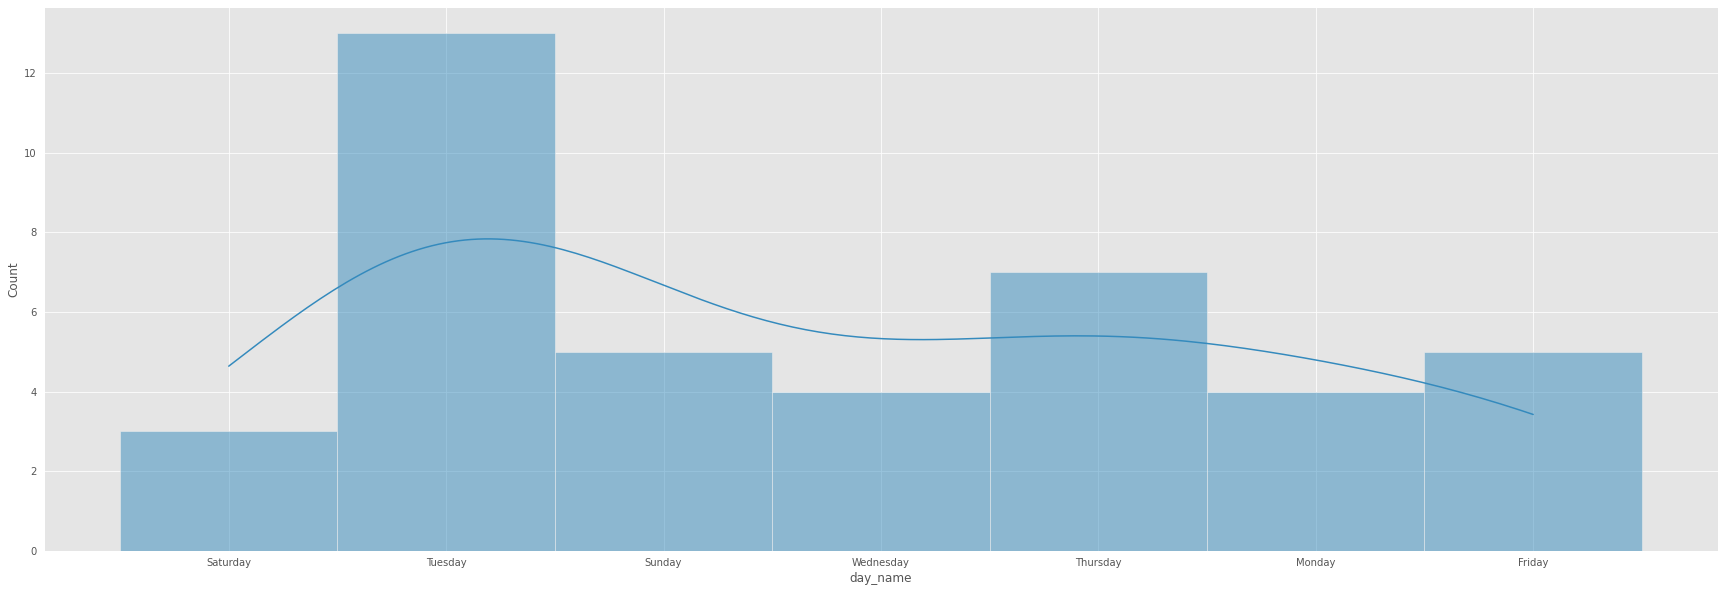

In [26]:
day_name_counts = df.day_name.value_counts(normalize=True)
sns.histplot(data=df, x="day_name", kde=True);

### Perguntas de interesse

- Qual foi a corrida mais longa em km? E em tempo?
- Qual foi a corrida com maior gasto calórico?
- Qual foi a corrida mais rápida (maior pace médio)?
- Como é minha performance por ambiente (velocidade, pace, calorias)?
- Como minha performance é afetada pela temperatura? E pelo clima?
- O horário do dia mostra alguma alteração nas métricas (melhora ou piora de performance)?

Também seria interessante ter uma visao de evolução das corridas, ao longo do tempo.
Ver quais são as tendências para as várias métricas.

## Data viz

In [27]:
def plot_time_series(x=None, y=None, title='title', xlabel=None, ylabel=None, label=''):
    plt.xticks(x)
    plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
def plot_barv(x=None, y=None, title='title', xlabel=None, ylabel=None, label=''):
    plt.bar(x, height=y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

### Categorical data

In [28]:
gb_day_name = df.groupby(by=['day_name']).agg({'sum', 'mean', 'max', 'min', p90})
gb_day_name.head()

/home/tuts/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


0        distance_total_KM                                            \
                       max      mean        p90       min        sum   
day_name                                                               
Friday            4.103880  2.814013   3.918286  1.347184  14.070067   
Monday            3.391853  2.341954   3.372685  0.191853   9.367815   
Saturday         11.153372  6.982673   9.944611  4.685079  20.948019   
Sunday           13.594162  7.923038  12.686134  3.638666  39.615188   
Thursday          8.822414  4.543186   7.861592  0.689111  31.802301   

0        nikefuel_total_FUEL                                        \
                         max         mean          p90         min   
day_name                                                             
Friday           1016.413013   683.963040   937.318937  346.461926   
Monday            959.428604   566.747838   881.517932   37.503823   
Saturday         2813.362058  1709.475790  2517.697234  980.027373   
Sunday           3263.628182  1963.563985  3150.940009  767.907156   
Thursday         2316.775291  1179.539719  2078.599448  142.842340   

0                     pace_mean_MKM                                            \
                  sum           max      mean        p90       min        sum   
day_name                                                                        
Friday    3419.815199      8.751978  8.036552   8.678516  7.456497  40.182758   
Monday    2266.991354     10.997135  9.479707  10.876622  8.132233  37.918827   
Saturday  5128.427369     13.162969  8.987420  11.927019  6.816072  26.962261   
Sunday    9817.819923      9.083508  7.758584   8.650579  7.008792  38.792919   
Thursday  8256.778032     11.809370  7.894118  10.749818  6.175867  55.258824   

0        steps_total_N                                   heart_rate_mean_BPM  \
                   max     mean     p90     min      sum                 max   
day_name                                                                       
Friday          4115.0  2946.60  4016.6  1393.0  14733.0          162.363636   
Monday          4324.0  2687.25  4115.8   233.0  10749.0          155.523810   
Saturday        6630.0  5777.50  6459.5  4925.0  11555.0          145.445521   
Sunday          4018.0  4005.50  4015.5  3993.0   8011.0          143.779661   
Thursday         925.0   884.00   916.8   843.0   1768.0          115.546392   

0                                                        speed_mean_KMH  \
                mean         p90         min         sum            max   
day_name                                                                  
Friday    151.466757  160.643660  134.928000  757.333783       8.046674   
Monday    139.970876  155.419888  109.384615  419.912627       7.378048   
Saturday  145.445521  145.445521  145.445521  145.445521       8.802724   
Sunday    143.779661  143.779661  143.779661  143.779661       8.560677   
Thursday  109.778351  114.392784  104.010309  219.556701       9.715235   

0                                                 nikefuel_mean_FUEL  \
              mean       p90       min        sum                max   
day_name                                                               
Friday    7.496646  7.948750  6.855593  37.483232          34.449426   
Monday    6.454809  7.361354  5.455967  25.819236          35.183341   
Saturday  7.317664  8.760584  4.558242  21.952991          38.333216   
Sunday    7.798805  8.437633  6.605378  38.994023          37.570560   
Thursday  8.014240  9.459873  5.080711  56.099678          42.512366   

0                                                     calories_total_KCAL  \
               mean        p90        min         sum                 max   
day_name                                                                    
Friday    30.844984  34.002571  25.543792  154.224921             381.136   
Monday    25.245786  33.194470  17.775728  100.983144             333.581   
Saturday 

In [29]:
gb_hour_of_the_day = df.groupby(by=['hour_of_the_day']).agg({'sum', 'mean', 'max', 'min', p90})
gb_hour_of_the_day.head()

0               distance_total_KM                                            \
                              max      mean        p90       min        sum   
hour_of_the_day                                                               
11                       3.391853  3.325893   3.378661  3.259933   6.651787   
14                       3.576777  3.576777   3.576777  3.576777   3.576777   
15                       4.685079  4.685079   4.685079  4.685079   4.685079   
16                       6.734412  6.734412   6.734412  6.734412   6.734412   
17                      11.153372  5.665693  10.380079  1.347184  45.325540   

0               nikefuel_total_FUEL                                         \
                                max         mean          p90          min   
hour_of_the_day                                                              
11                       818.677824   759.202094   806.782678   699.726364   
14                       893.926649   893.926649   893.926649   893.926649   
15                       980.027373   980.027373   980.027373   980.027373   
16                      1723.000606  1723.000606  1723.000606  1723.000606   
17                      2813.362058  1442.143526  2673.132874   346.461926   

0                             pace_mean_MKM                                   \
                          sum           max       mean        p90        min   
hour_of_the_day                                                                
11                1518.404188     10.595426   9.673702  10.411081   8.751978   
14                 893.926649      7.094874   7.094874   7.094874   7.094874   
15                 980.027373     13.162969  13.162969  13.162969  13.162969   
16                1723.000606      6.881781   6.881781   6.881781   6.881781   
17               11537.148204      8.568322   7.267739   8.263060   5.950347   

0                          steps_total_N                                  \
                       sum           max    mean     p90     min     sum   
hour_of_the_day                                                            
11               19.347405        4324.0  3992.0  4257.6  3660.0  7984.0   
14                7.094874        3434.0  3434.0  3434.0  3434.0  3434.0   
15               13.162969        6630.0  6630.0  6630.0  6630.0  6630.0   
16                6.881781           NaN     NaN     NaN     NaN     0.0   
17               58.141915        3869.0  2608.0  3607.6  1393.0  7824.0   

0               heart_rate_mean_BPM                                      \
                                max        mean         p90         min   
hour_of_the_day                                                           
11                       162.363636  162.363636  162.363636  162.363636   
14                       163.032787  163.032787  163.032787  163.032787   
15                              NaN         NaN         NaN         NaN   
16                              NaN         NaN         NaN         NaN   
17                       155.004202  146.656545  154.010848  134.928000   

0                           speed_mean_KMH                                \
                        sum            max      mean       p90       min   
hour_of_the_day                                                            
11               162.363636       6.855593  6.259207  6.736316  5.662821   
14               163.032787       8.456810  8.456810  8.456810  8.456810   
15                 0.000000       4.558242  4.558242  4.558242  4.558242   
16                 0.000000       8.718673  8.718673  8.718673  8.718673   
17               439.969635      10.083445  8.354968  9.317934  7.002538   

0                          nikefuel_mean_FUEL                        \
                       sum                max       mean        p90   
hour_of_the_day                                                       
11               12.518414          28.694460  24.082382  27.772045  

#### Distância por hora do dia

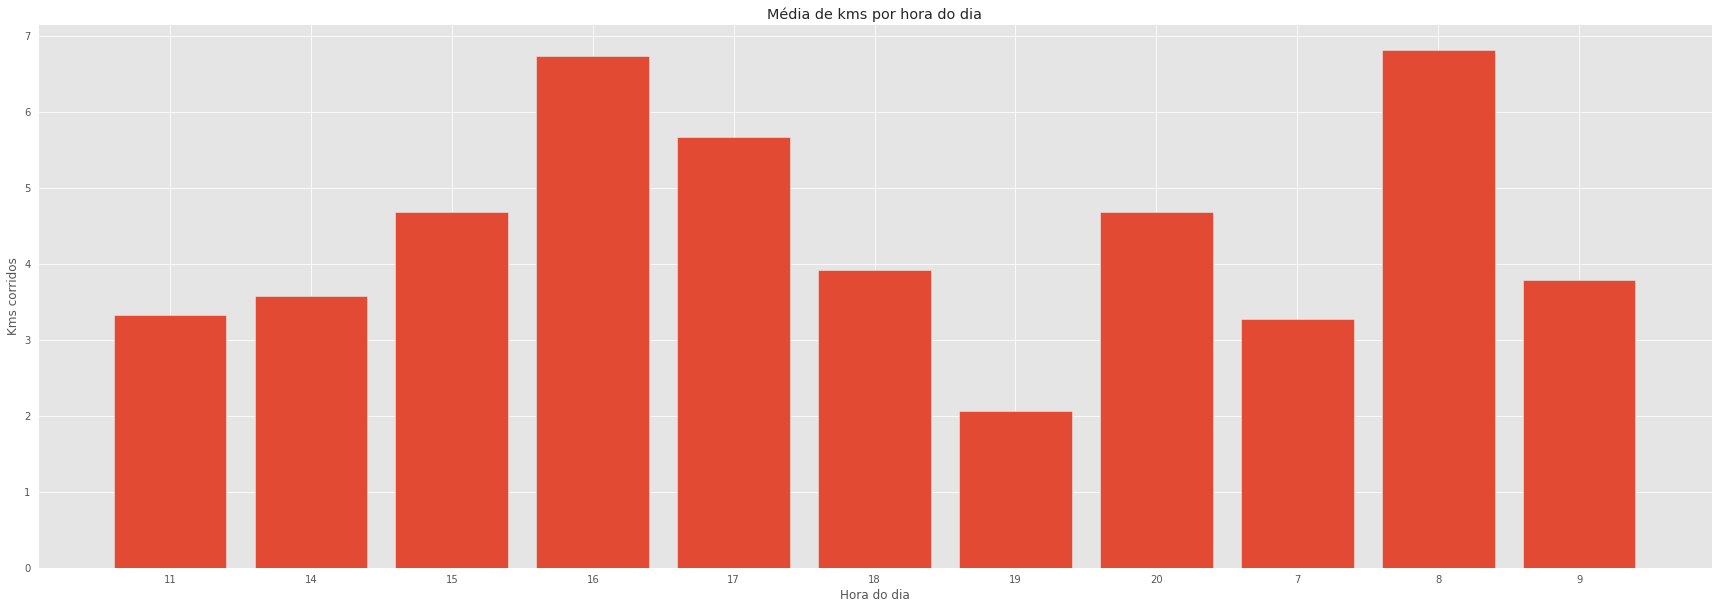

In [30]:
plot_barv(x=gb_hour_of_the_day.distance_total_KM['mean'].index, y=gb_hour_of_the_day.distance_total_KM['mean'].values, title='Média de kms por hora do dia', xlabel='Hora do dia', ylabel='Kms corridos');

#### Distância por dia da semana

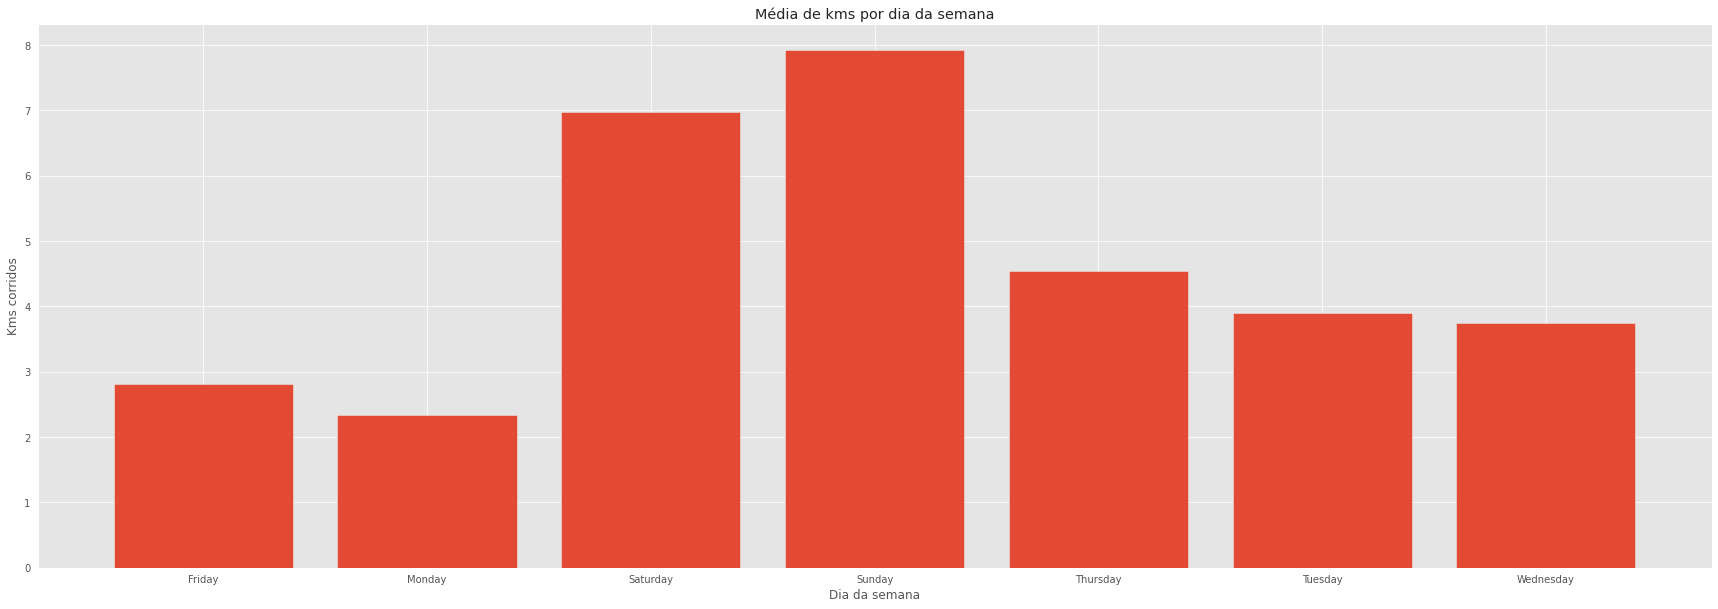

In [31]:
plot_barv(x=gb_day_name.distance_total_KM['mean'].index, y=gb_day_name.distance_total_KM['mean'].values, title='Média de kms por dia da semana', xlabel='Dia da semana', ylabel='Kms corridos');

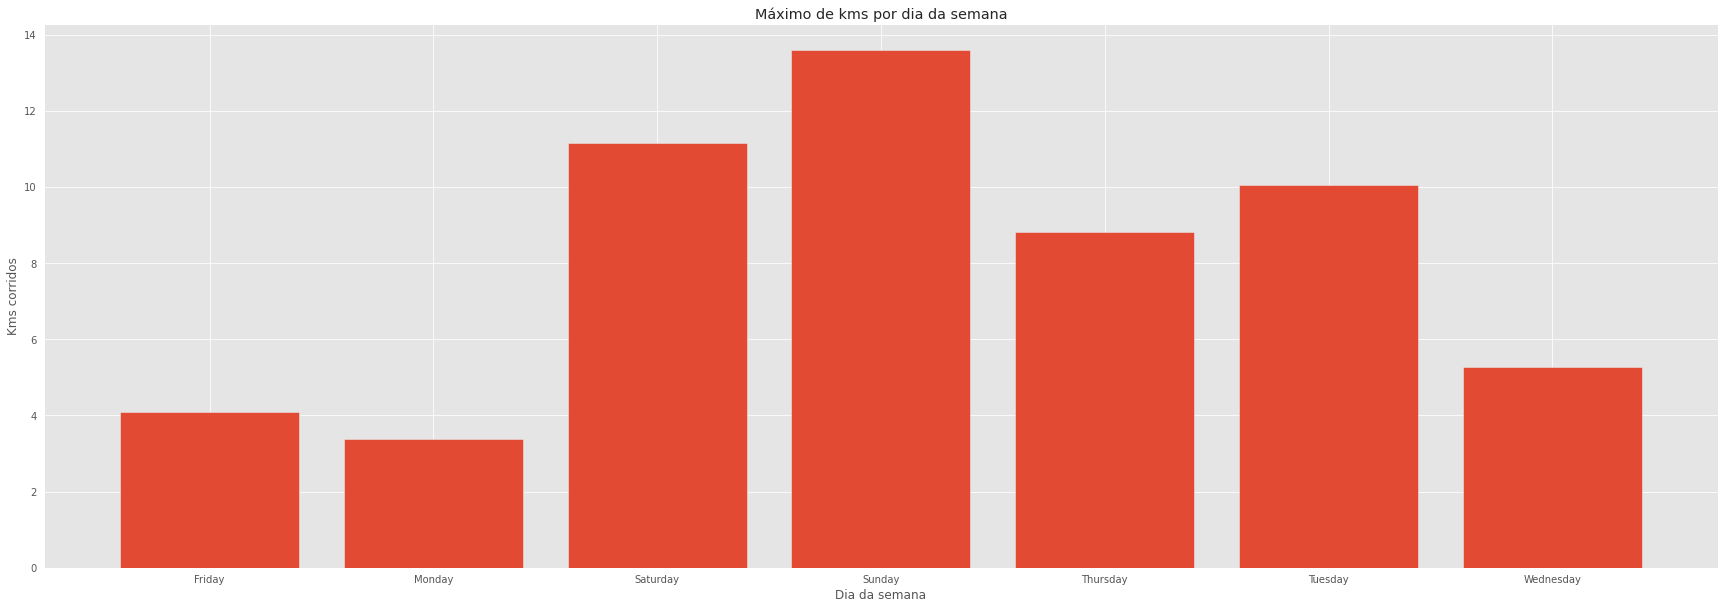

In [32]:
plot_barv(x=gb_day_name.distance_total_KM['max'].index, y=gb_day_name.distance_total_KM['max'].values, title='Máximo de kms por dia da semana', xlabel='Dia da semana', ylabel='Kms corridos');

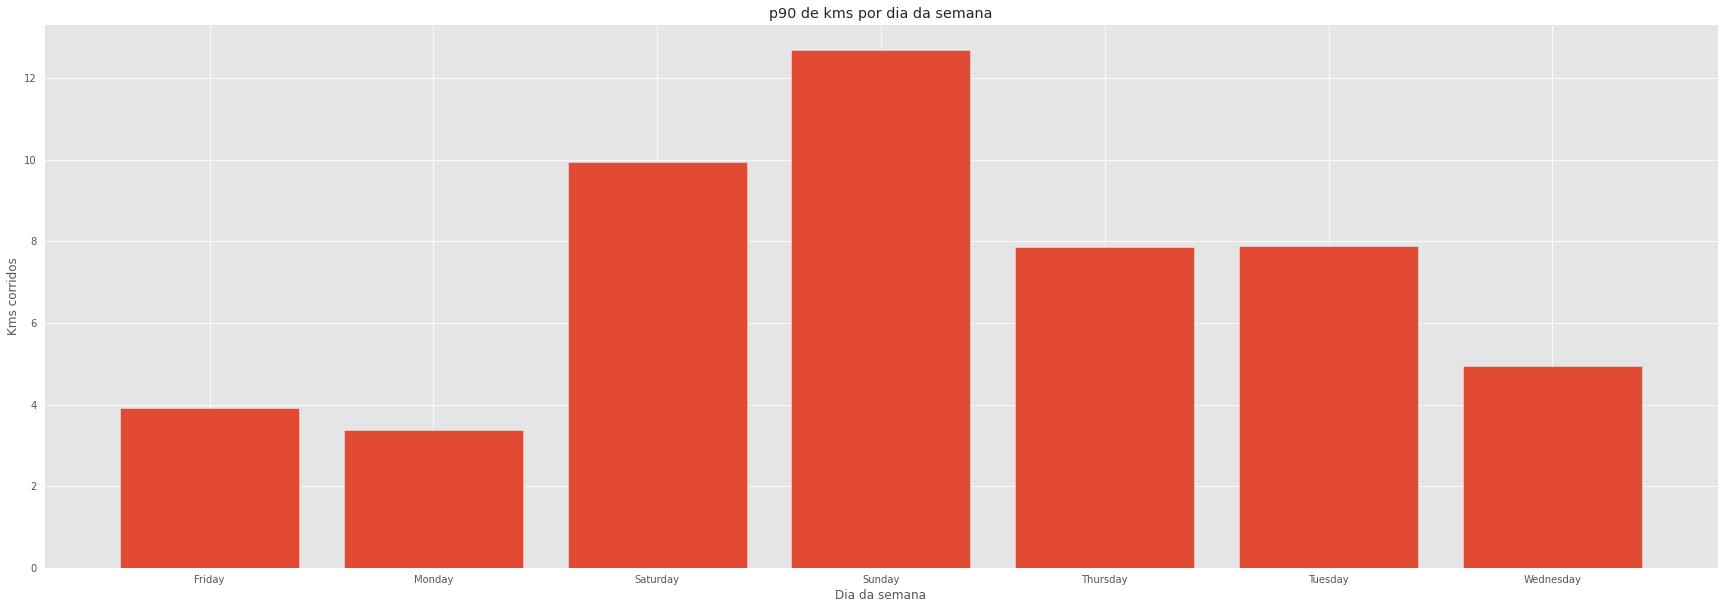

In [33]:
plot_barv(x=gb_day_name.distance_total_KM['p90'].index, y=gb_day_name.distance_total_KM['p90'].values, title='p90 de kms por dia da semana', xlabel='Dia da semana', ylabel='Kms corridos');

#### Pace por dia da semana

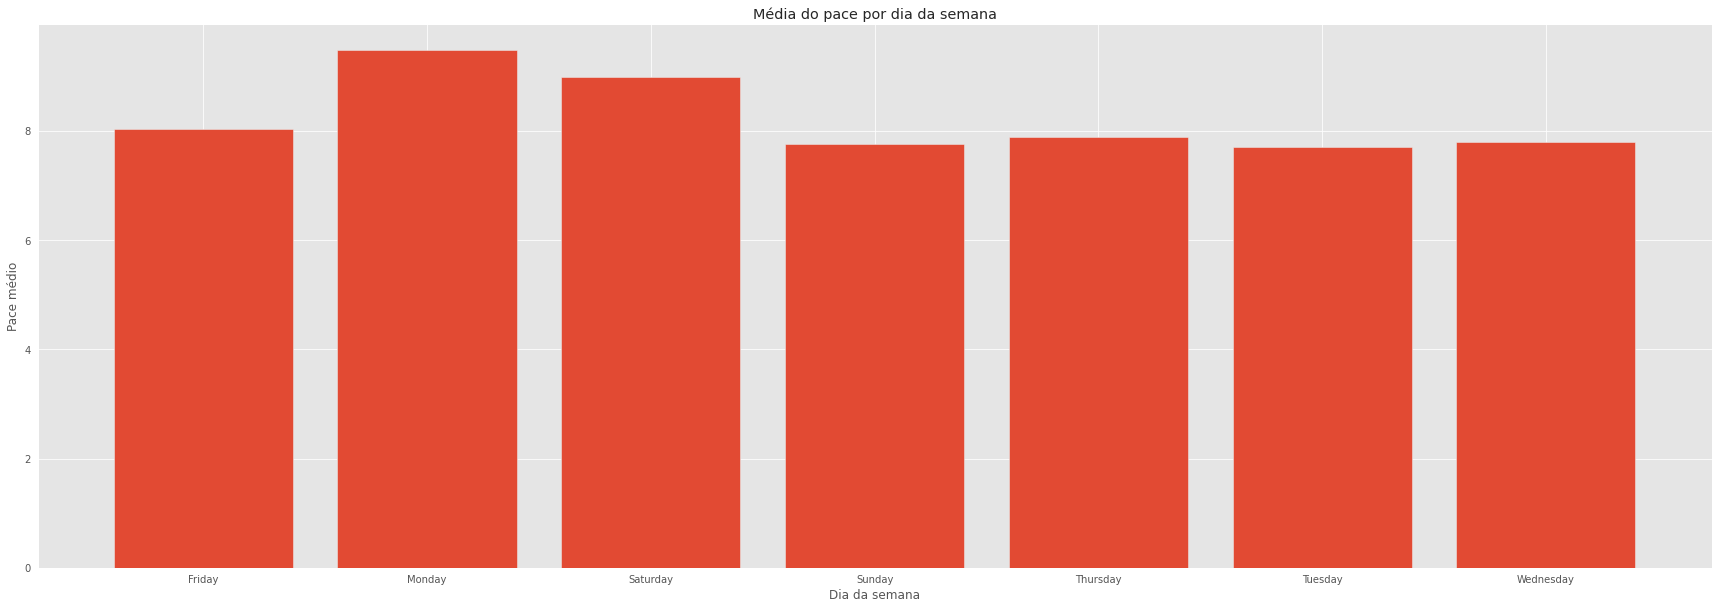

In [34]:
plot_barv(x=gb_day_name.pace_mean_MKM['mean'].index, y=gb_day_name.pace_mean_MKM['mean'].values, title='Média do pace por dia da semana', xlabel='Dia da semana', ylabel='Pace médio');

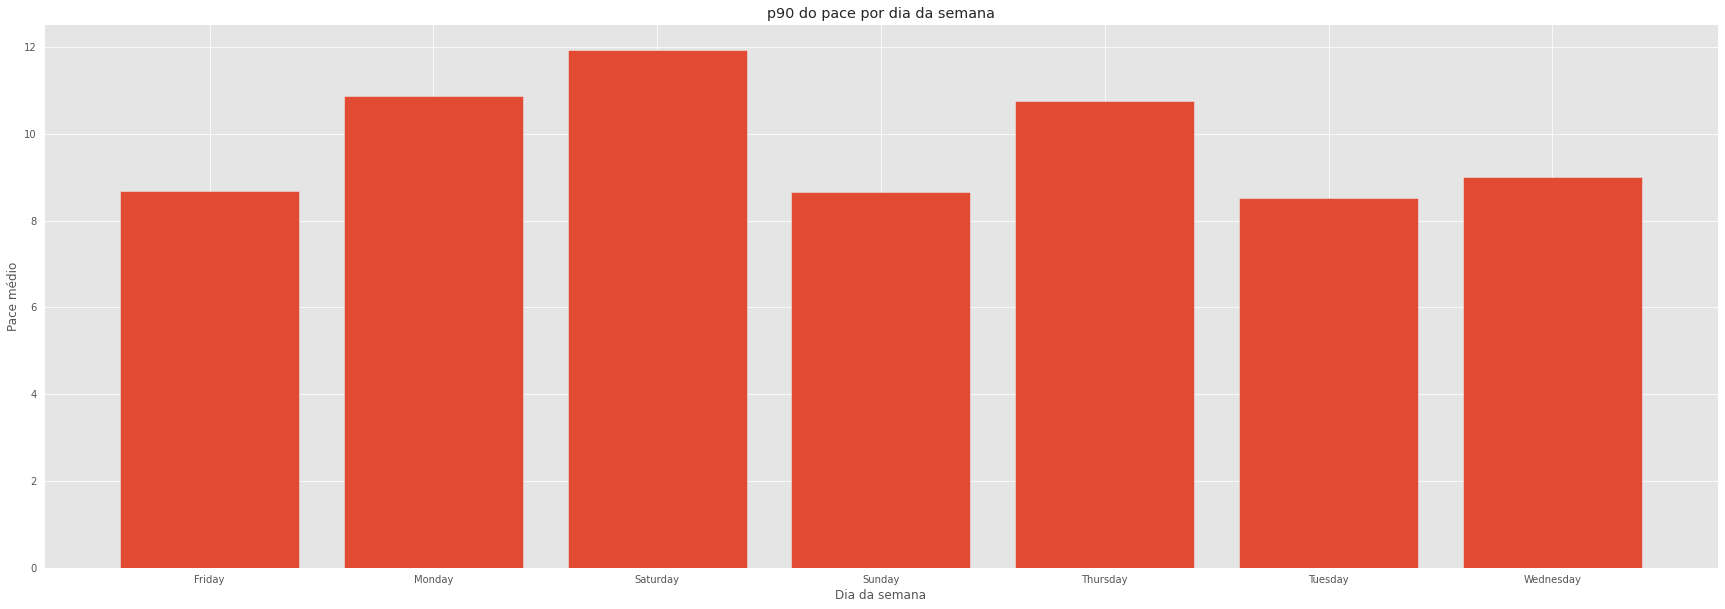

In [35]:
plot_barv(x=gb_day_name.pace_mean_MKM['p90'].index, y=gb_day_name.pace_mean_MKM['p90'].values, title='p90 do pace por dia da semana', xlabel='Dia da semana', ylabel='Pace médio');

### Scatter plots

Será que existe alguma relação entre sensação térmica e distância e pace?

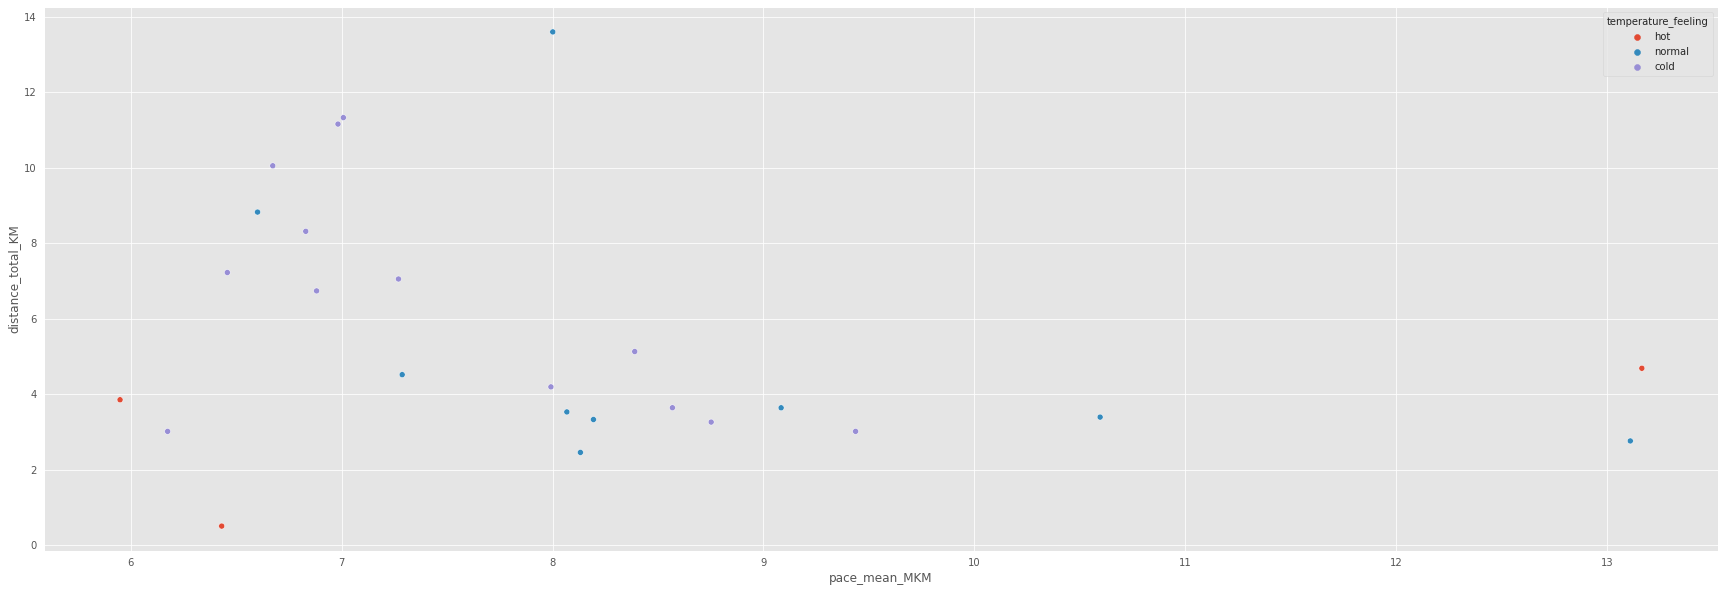

In [65]:
sns.scatterplot(x=df.pace_mean_MKM, y=df.distance_total_KM, hue=df.temperature_feeling, data=df);

Velocidade vs distância por sensação térmica tem um gráfico bem semelhante:

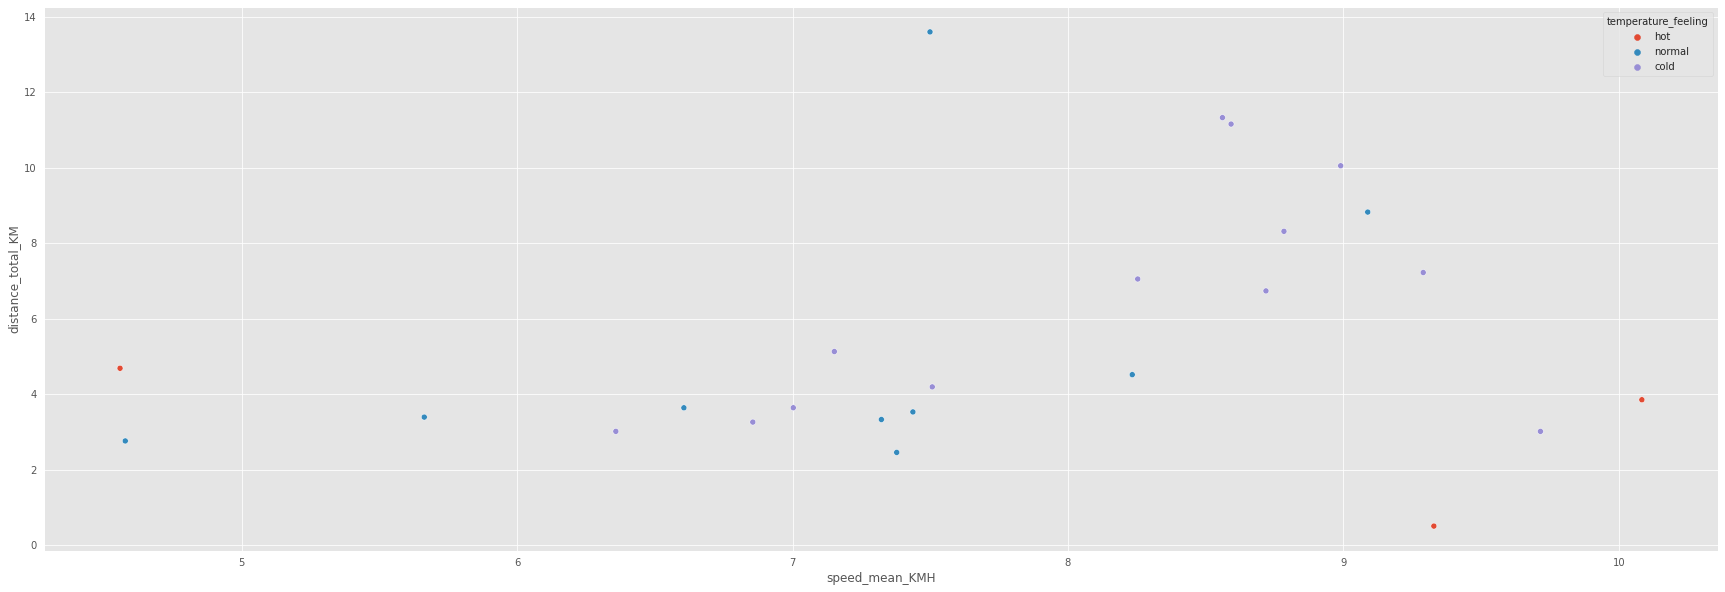

In [67]:
sns.scatterplot(x=df.speed_mean_KMH, y=df.distance_total_KM, hue=df.temperature_feeling, data=df);

Agora tentando observar em relação a hora do dia. Será que dependendo da hora do dia, tenho mais velocidade e corro uma maior distância?

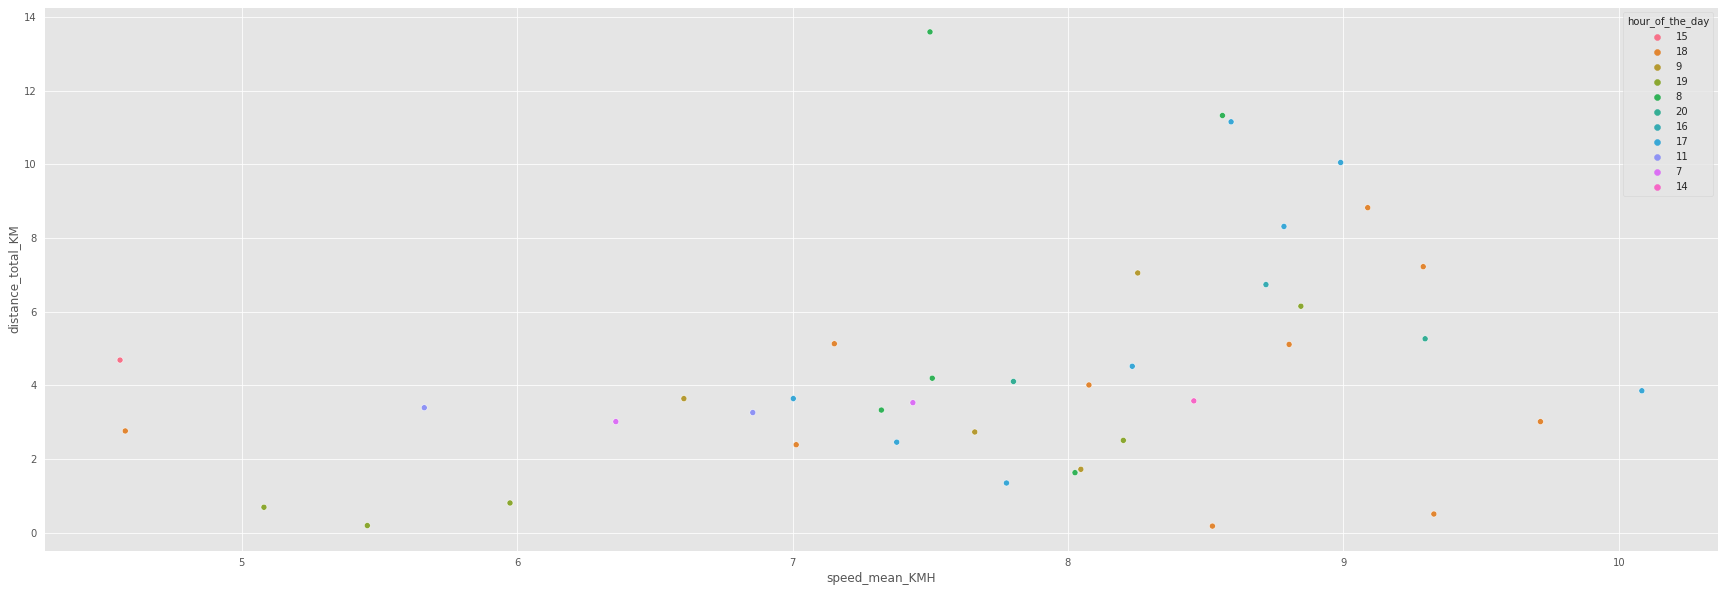

In [68]:
sns.scatterplot(x=df.speed_mean_KMH, y=df.distance_total_KM, hue=df.hour_of_the_day, data=df);

### Time series

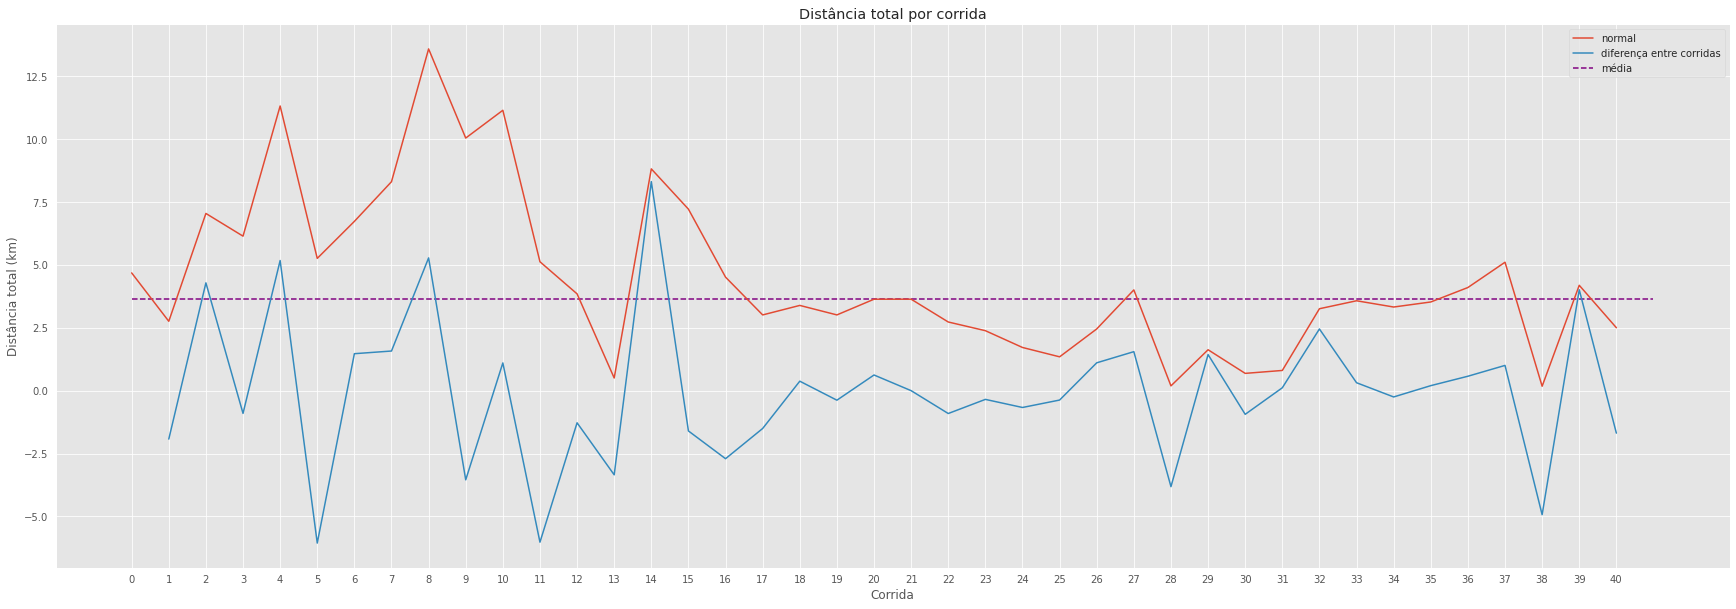

In [36]:
plot_time_series(x=range(len(df)), y=df.distance_total_KM, label='normal');
plt.hlines(df.distance_total_KM.median(), color='purple', linestyle='dashed', label='média', xmin=0, xmax=len(df))
plot_time_series(x=range(len(df)), y=df.distance_total_diff, title='Distância total por corrida', xlabel='Corrida', ylabel='Distância total (km)', label='diferença entre corridas');

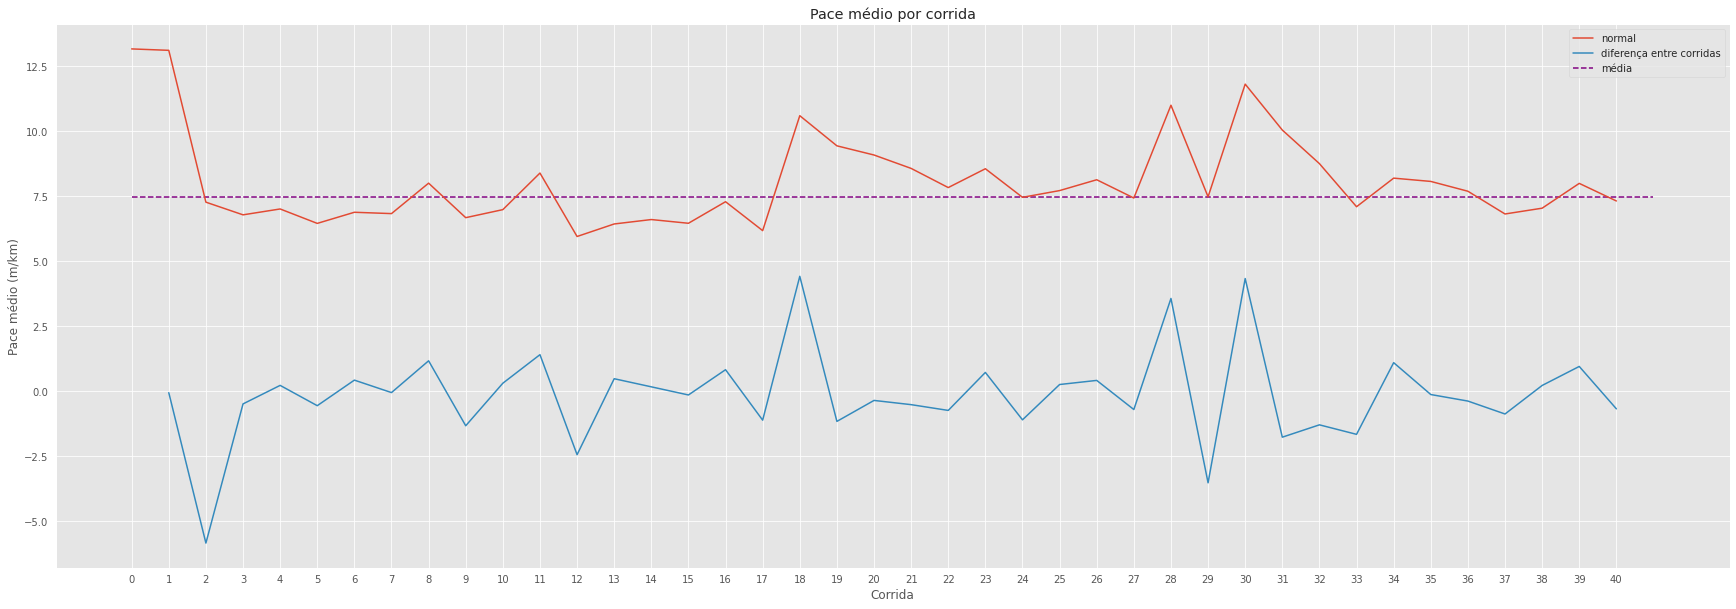

In [37]:
plot_time_series(x=range(len(df)), y=df.pace_mean_MKM, label='normal');
plt.hlines(df.pace_mean_MKM.median(), color='purple', linestyle='dashed', label='média', xmin=0, xmax=len(df))
plot_time_series(x=range(len(df)), y=df.pace_mean_MKM.diff(), title='Pace médio por corrida', xlabel='Corrida', ylabel='Pace médio (m/km)', label='diferença entre corridas');

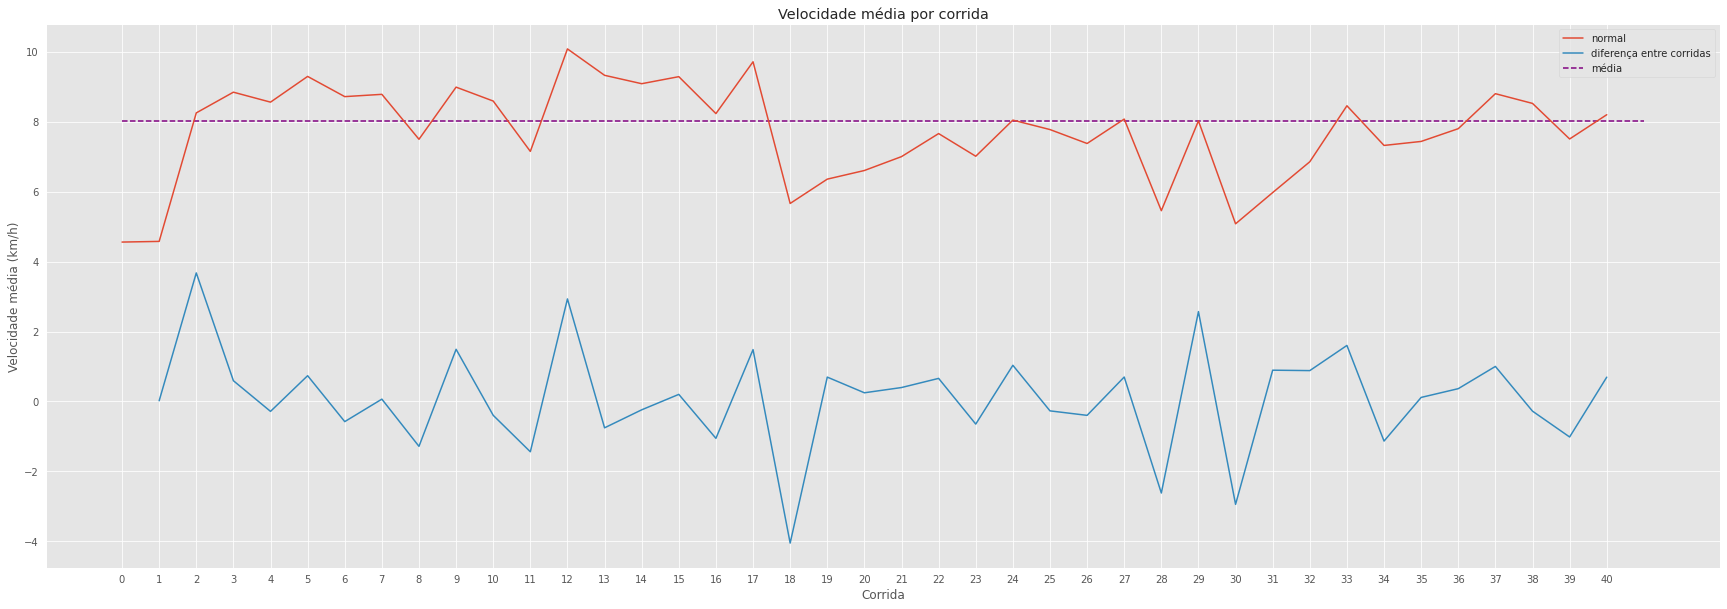

In [38]:
plot_time_series(x=range(len(df)), y=df.speed_mean_KMH, label='normal');
plt.hlines(df.speed_mean_KMH.median(), color='purple', linestyle='dashed', label='média', xmin=0, xmax=len(df))
plot_time_series(x=range(len(df)), y=df.speed_mean_KMH.diff(), title='Velocidade média por corrida', xlabel='Corrida', ylabel='Velocidade média (km/h)', label='diferença entre corridas');

#### Diferença em dias sem correr vs pace médio (p90 dos dias sem correr porque fiquei um período longo sem corridas)

In [60]:
days_diff_below_p90 = df[df.days_diff < df.days_diff.quantile(.9)]

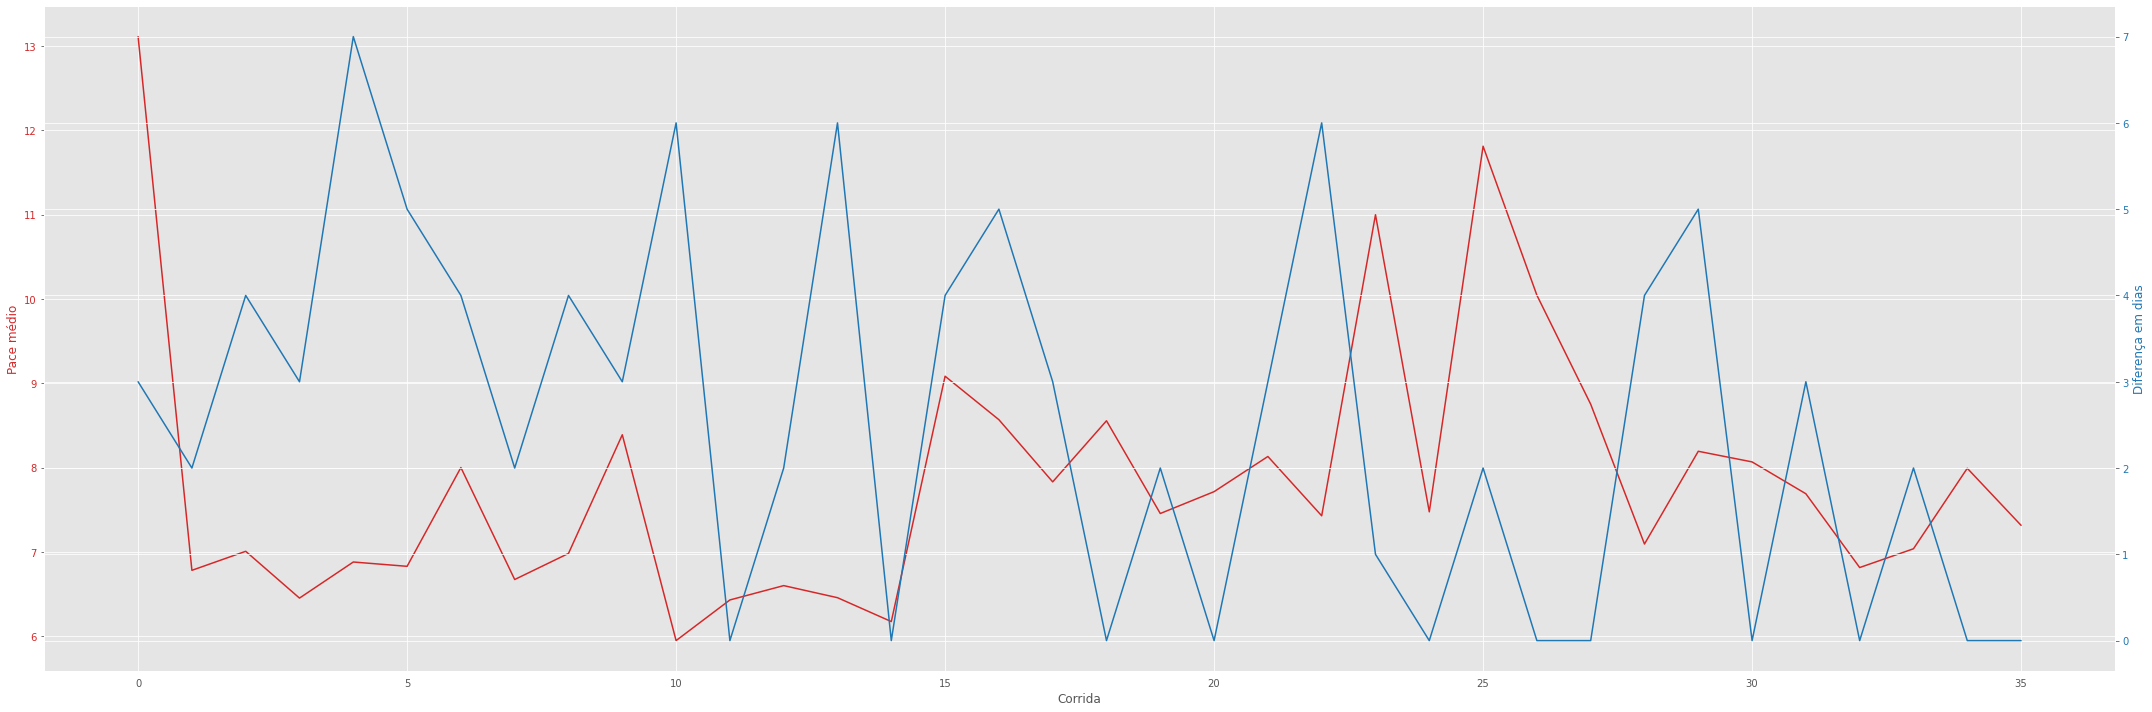

In [61]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Corrida')
ax1.set_ylabel('Pace médio', color=color)
ax1.plot(range(len(days_diff_below_p90)), days_diff_below_p90.pace_mean_MKM, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Diferença em dias', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(days_diff_below_p90)), days_diff_below_p90.days_diff, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Diferença em dias sem correr vs distância média

Esperava ver mais claramente uma correlação negativa entre um e outro, indicando que se eu fico mais tempo sem correr, corro menos.

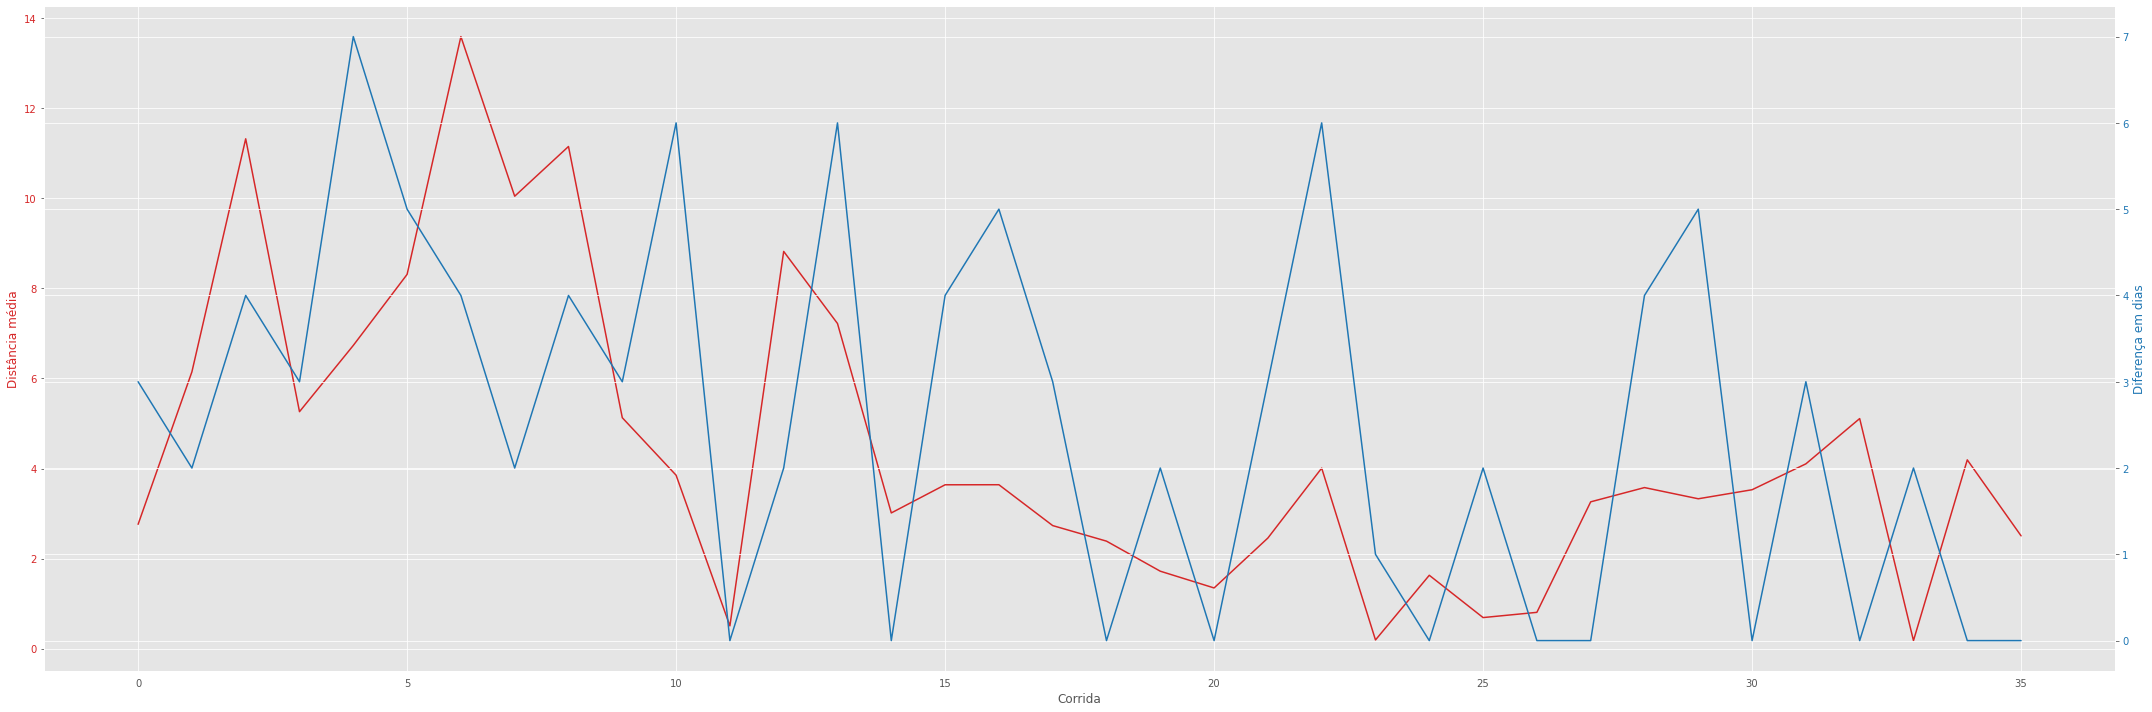

In [78]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Corrida')
ax1.set_ylabel('Distância média', color=color)
ax1.plot(range(len(days_diff_below_p90)), days_diff_below_p90.distance_total_KM, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Diferença em dias', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(days_diff_below_p90)), days_diff_below_p90.days_diff, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Correlations

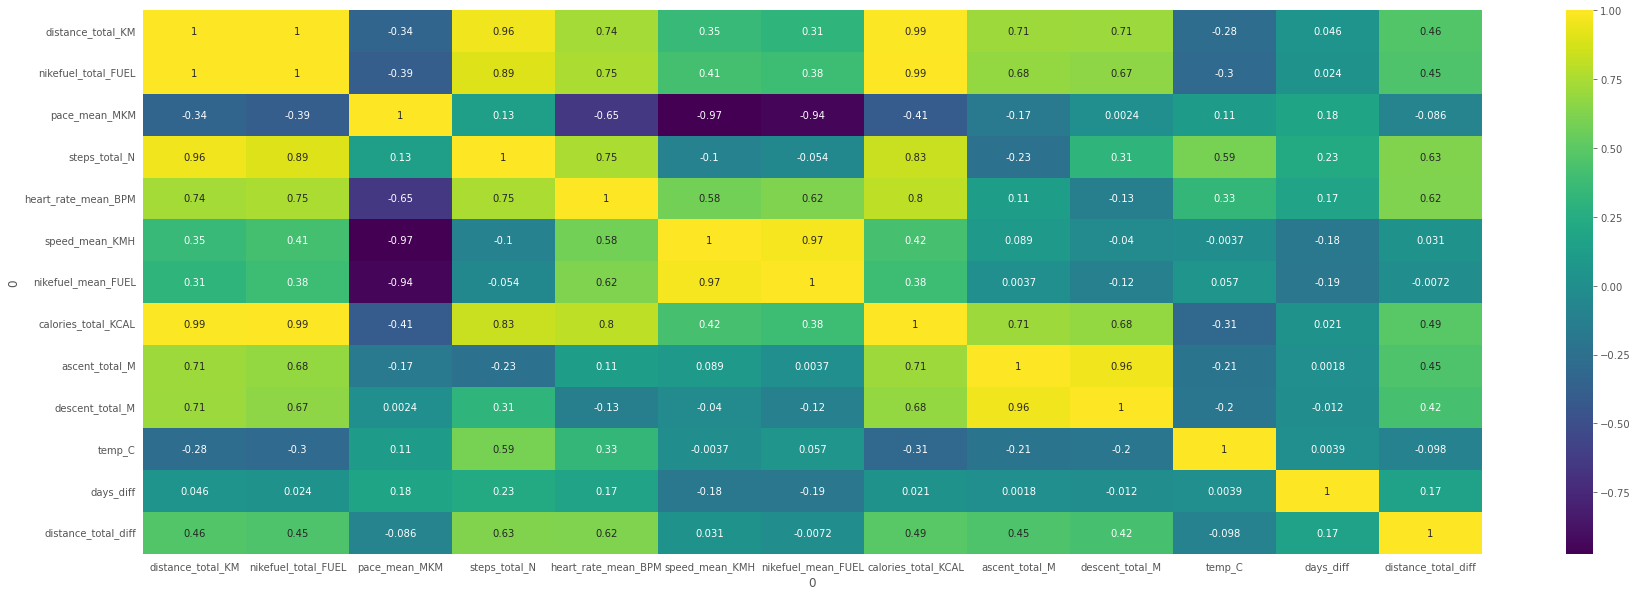

In [84]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis');

O gráfico abaixo não mostra muito.

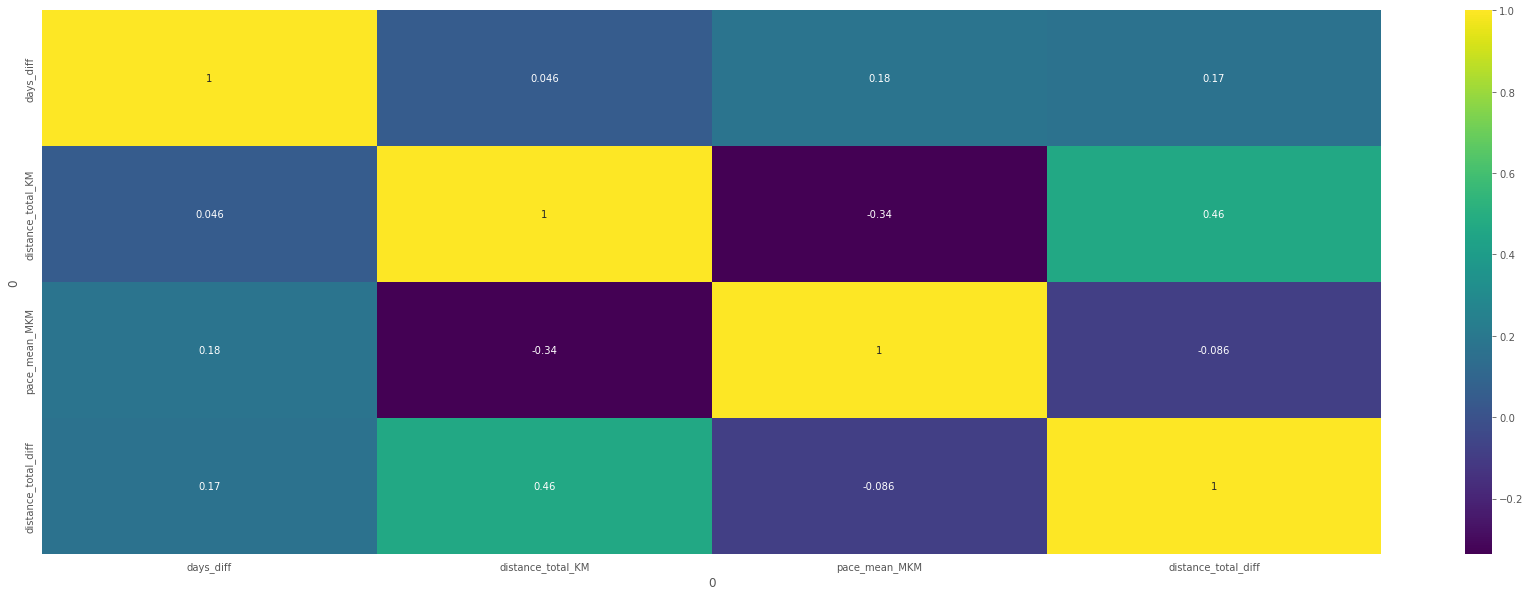

In [83]:
normalized_df=df[['days_diff', 'distance_total_KM', 'pace_mean_MKM', 'distance_total_diff']]#-df[['days_diff', 'distance_total_KM', 'pace_mean_MKM']].mean())/df[['days_diff', 'distance_total_KM', 'pace_mean_MKM', 'distance_total_diff']].std()
corr = normalized_df.corr()
sns.heatmap(corr, annot=True, cmap='viridis');